In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import random
import pickle

In [2]:
from lib.data import generate_profiles
from lib.functions import *
from lib.model import tfidf

In [3]:
# for confusion matrix
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plt.show()

Automatically created module for IPython interactive environment


# Profiles
Here we generate some profiles

In [4]:
n = 10
topics = [
    'business',
    'entertainment',
    'politics',
    'sport',
    'tech',
]

profiles = generate_profiles(n, topics)
profiles

{0: ['business', 'politics'],
 1: ['politics', 'entertainment', 'business'],
 2: ['business', 'sport', 'politics'],
 3: ['politics'],
 4: ['politics', 'tech', 'business', 'sport'],
 5: ['entertainment', 'business', 'politics'],
 6: ['politics', 'business', 'entertainment', 'tech', 'sport'],
 7: ['entertainment'],
 8: ['tech', 'entertainment'],
 9: ['sport', 'tech', 'politics']}

# Train model

In [5]:
tfidf_model = tfidf()
path = os.path.join('bbc-fulltext')              
tfidf_model.get_articles(path)
tfidf_model.split_data()

Number of articles: 2225
Training: 2002
Test: 223


In [6]:
%time tfidf_model.train()

Wall time: 20.6 s


# Test model on a single example

In [7]:
text = '''
Anelka, 25, is in talks over a contract extension beyond 2007 with City but is believed to fear his career 
will go stale if he stays at the club. The News of the World reports that Anelka told a French magazine: 
"I either decide to win titles or to have an easy life. 
"I think I will always choose football, if a great club makes me an offer.
'''
ranking = tfidf_model.get_ranking(text)

In [8]:
counter = 0
for doc, score in ranking:
    print("[ Score = " + "%.3f" % round(score,3) + "] " + tfidf_model.train_set[doc]['category'])
    print(tfidf_model.train_set[doc]['text'])
    counter+=1
    if counter > 3: break

[ Score = 0.610] sport
Anelka 'eyes Man City departure'

Striker Nicolas Anelka reportedly wants to leave Manchester City in search of Champions League football.

Anelka, 25, is in talks over a contract extension beyond 2007 with City but is believed to fear his career will go stale if he stays at the club. The News of the World reports that Anelka told a French magazine: "I either decide to win titles or to have an easy life. "I think I will always choose football, if a great club makes me an offer." He added: "To win titles you need players who have the capability of doing so. If we stagnate between eighth and 15th place it's impossible to progress. "If I am going to score goals and not win, there is a risk it is going to create a feeling of being fed up." Anelka has earned a reputation for being a difficult character to handle after spells at Arsenal, Real Madrid and Paris St Germain and he feels that is now coming back to haunt him.

"I am in talks to sign an extension to my contra

In [9]:
tfidf_model.predict(text)

'sport'

# Evaluate on test set

In [10]:
%%time
true_labels = [a['category'] for a in tfidf_model.test_set]
predictions = []

for a in tfidf_model.test_set:
    predictions.append(tfidf_model.predict(a['text']))

Wall time: 1min 38s


Accuracy score: 0.9551569506726457
Confusion matrix, without normalization
[[56  0  2  0  3]
 [ 0 40  0  1  0]
 [ 1  0 30  0  0]
 [ 1  0  0 47  0]
 [ 0  1  1  0 40]]


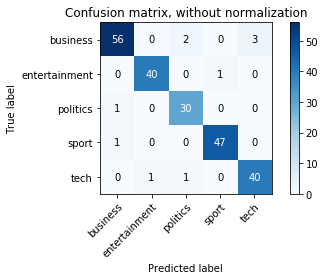

In [11]:
print('Accuracy score:', accuracy_score(true_labels, predictions))

# Plot non-normalized confusion matrix
plot_confusion_matrix(true_labels, predictions, classes=topics,
                      title='Confusion matrix, without normalization')

# Article assignment
Here we need to assign some articles

In [12]:
new_article = text

# assign topic to article
article_topic = tfidf_model.predict(new_article)
print(article_topic)

for profile, profile_topics in profiles.items():
    print(profile, profile_topics)
    if article_topic in profile_topics:
        print('Article assigned to user', profile)
    else:
        pass

sport
0 ['business', 'politics']
1 ['politics', 'entertainment', 'business']
2 ['business', 'sport', 'politics']
Article assigned to user 2
3 ['politics']
4 ['politics', 'tech', 'business', 'sport']
Article assigned to user 4
5 ['entertainment', 'business', 'politics']
6 ['politics', 'business', 'entertainment', 'tech', 'sport']
Article assigned to user 6
7 ['entertainment']
8 ['tech', 'entertainment']
9 ['sport', 'tech', 'politics']
Article assigned to user 9


In [13]:
# save model
pickle.dump(tfidf_model, open('models/tfidf_model.pickle', 'wb'))